# 2 
Модифицировать код функции get_user_embedding таким образом, чтобы считалось не среднее (как в примере np.mean), а медиана. Применить такое преобразование к данным, обучить модель прогнозирования оттока и посчитать метрики качества и сохранить их: roc auc, precision/recall/f_score (для 3 последних - подобрать оптимальный порог)

# 3
Повторить п.2, но используя уже не медиану, а max

In [75]:
#импортируем необходимые библиотеки
import pandas as pd
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

Далее повторим весь код который был на уроке

In [76]:
#загрузим новостную ленту
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt 

--2022-02-27 16:29:34--  https://docs.google.com/uc?export=download&confirm=t&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR
Распознаётся docs.google.com (docs.google.com)... 64.233.163.194, 2a00:1450:4010:c06::c2
Подключение к docs.google.com (docs.google.com)|64.233.163.194|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 303 See Other
Адрес: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dtktudpnhf0ef98dqplh6qf5qtjku2d3/1645968525000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download [переход]
Предупреждение: в HTTP шаблоны не поддерживаются.
--2022-02-27 16:29:35--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/dtktudpnhf0ef98dqplh6qf5qtjku2d3/1645968525000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download
Распознаётся doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 142.251.1.132, 2a00:1450:4010:c1e::84
Подключен

In [77]:
news = pd.read_csv("articles.csv")

(27000, 2)


,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...


In [78]:
#загружаем пользователей
!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv

--2022-02-27 16:32:31--  https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a
Распознаётся drive.google.com (drive.google.com)... 64.233.163.194, 2a00:1450:4010:c06::c2
Подключение к drive.google.com (drive.google.com)|64.233.163.194|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 303 See Other
Адрес: https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qe33330ks7el4o0uektbbqok8tldostu/1645968750000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download [переход]
Предупреждение: в HTTP шаблоны не поддерживаются.
--2022-02-27 16:32:31--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/qe33330ks7el4o0uektbbqok8tldostu/1645968750000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download
Распознаётся doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)... 142.251.1.132, 2a00:1450:4010:c1e::84
Подключение к 

In [79]:
users = pd.read_csv("users_articles.csv")

In [80]:
#загружаем стопслова
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stopword_ru = stopwords.words('russian')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vasiliy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [81]:

!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt

--2022-02-27 16:33:45--  https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c
Распознаётся drive.google.com (drive.google.com)... 64.233.163.194, 2a00:1450:4010:c06::c2
Подключение к drive.google.com (drive.google.com)|64.233.163.194|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 303 See Other
Адрес: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c2l5pbtn6gelslgs38bkhcgqpdutt0uu/1645968825000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download [переход]
Предупреждение: в HTTP шаблоны не поддерживаются.
--2022-02-27 16:33:45--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/c2l5pbtn6gelslgs38bkhcgqpdutt0uu/1645968825000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download
Распознаётся doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 142.251.1.132, 2a00:1450:4010:c1e::84
Подключение к 

In [82]:
#открываем документ со стопсловами и создаем списов
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords


In [ ]:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [97]:
from tqdm import tqdm
tqdm.pandas()
from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)
# Запускаем очистку текста. Будет долго...
news['title'] = news['title'].progress_apply(lambda x: clean_text(x))


INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


100%|██████████| 27000/27000 [00:56<00:00, 473.80it/s] 


In [98]:
%%time
# Запускаем лемматизацию текста. Будет очень долго...
news['title'] = news['title'].progress_apply(lambda x: lemmatization(x))

100%|██████████| 27000/27000 [06:19<00:00, 71.06it/s] 


CPU times: user 6min 19s, sys: 2.43 s, total: 6min 21s
Wall time: 6min 19s


In [99]:
# сформируем список наших текстов
texts = list(news['title'].values)

# Создадим корпус из списка с текстами
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]

In [100]:
N_topic = 20

In [101]:
%%time
from gensim.models import LdaModel

# Обучаем модель на корпусе
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 2min 2s, sys: 1min 33s, total: 3min 36s
Wall time: 1min 40s


In [102]:
from gensim.test.utils import datapath

# Сохраняем модель на диск
temp_file = datapath("model.lda")
lda.save(temp_file)

In [103]:
# Загружаем обученную модель с диска
lda = LdaModel.load(temp_file)

In [104]:
# Создаем новый корпус документов, которые раньше не видели
other_texts = list(news['title'].iloc[:3])
other_corpus = [common_dictionary.doc2bow(text) for text in other_texts]

unseen_doc = other_corpus[2]
print(other_texts[2])
lda[unseen_doc]

['форвард', 'авангард', 'томаш', 'заборский', 'прокомментировать', 'игра', 'команда', 'матч', 'чемпионат', 'кхл', 'против', 'атланта', 'плохой', 'матч', 'нижний', 'новгород', 'против', 'торпедо', 'настраиваться', 'первый', 'минута', 'включиться', 'заборский', 'получиться', 'забросить', 'быстрый', 'гол', 'задать', 'хороший', 'темп', 'поединок', 'играть', 'хороший', 'сторона', 'пять', 'очко', 'выезд', 'девять', 'хороший']


[(1, 0.2188915),
 (8, 0.24355476),
 (9, 0.11659205),
 (11, 0.24873912),
 (19, 0.15194076)]

In [105]:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [106]:
get_lda_vector(lda, news['title'].iloc[0])

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.3432498 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.64772928, 0.        ])

In [107]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

CPU times: user 1min 35s, sys: 1min 21s, total: 2min 57s
Wall time: 1min 17s


,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.341044,0.015977,0.0,0.0,0.0,0.000000,0.0,0.0,0.634488,0.000000
1,4896,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.304182,0.0,0.0,0.0,0.672119,0.0,0.0,0.000000,0.000000
2,4897,0.0,0.21892,0.0,0.0,0.0,0.0,0.0,0.0,0.243653,...,0.000000,0.248721,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.151989
3,4898,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.179127,...,0.000000,0.156504,0.0,0.0,0.0,0.653419,0.0,0.0,0.000000,0.000000
4,4899,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.885167,0.088318


In [108]:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))

In [109]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.mean(user_vector, 0)  # можно не среднее
    return user_vector

In [110]:
%%time
user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings.head(3)

CPU times: user 901 ms, sys: 13 ms, total: 914 ms
Wall time: 915 ms


,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.025378,0.085215,0.003703,0.0,0.037570,0.086958,0.010422,0.161614,0.018219,...,0.058387,0.002442,0.152782,0.052288,0.002824,0.084263,0.012563,0.011129,0.113969,0.004678
1,u108690,0.024086,0.102351,0.012476,0.0,0.006292,0.040294,0.000000,0.220039,0.005661,...,0.063600,0.001717,0.105452,0.056360,0.000000,0.159427,0.005270,0.002235,0.125314,0.031860
2,u108339,0.015169,0.086305,0.035419,0.0,0.003003,0.092810,0.013137,0.130906,0.008840,...,0.074956,0.007510,0.112486,0.039085,0.000000,0.143456,0.000000,0.002485,0.158837,0.051961


In [111]:
!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv

--2022-02-27 17:13:29--  https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK
Распознаётся drive.google.com (drive.google.com)... 64.233.163.194, 2a00:1450:4010:c06::c2
Подключение к drive.google.com (drive.google.com)|64.233.163.194|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа... 303 See Other
Адрес: https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b5ne130lpc3r99b20pcg850td5rabecl/1645971150000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download [переход]
Предупреждение: в HTTP шаблоны не поддерживаются.
--2022-02-27 17:13:30--  https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/b5ne130lpc3r99b20pcg850td5rabecl/1645971150000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download
Распознаётся doc-0k-c0-docs.googleusercontent.com (doc-0k-c0-docs.googleusercontent.com)... 142.251.1.132, 2a00:1450:4010:c1e::84
Подключение к 

In [112]:
target = pd.read_csv("users_churn.csv")
target.head(3)

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [113]:
X = pd.merge(user_embeddings, target, 'left')

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)
preds = logreg.predict_proba(X_test)[:, 1]

In [116]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix)

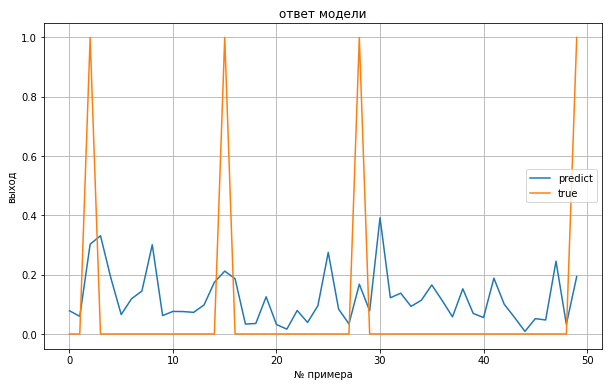

In [117]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

изменим функцию get_user_embedding используя median

In [118]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0)  # можно не среднее
    return user_vector

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)
preds_median = logreg.predict_proba(X_test)[:, 1]

изменим функцию get_user_embedding используя max

In [119]:
def get_user_embedding(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0)  # можно не среднее
    return user_vector

user_embeddings = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding(x, doc_dict))])
user_embeddings.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings['uid'] = users['uid'].values
user_embeddings = user_embeddings[['uid']+[f'topic_{i}' for i in range(N_topic)]]

X = pd.merge(user_embeddings, target, 'left')

X_train, X_test, y_train, y_test = train_test_split(X[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X['churn'], random_state=0)
logreg = LogisticRegression()
# обучим 
logreg.fit(X_train, y_train)
preds_max = logreg.predict_proba(X_test)[:, 1]

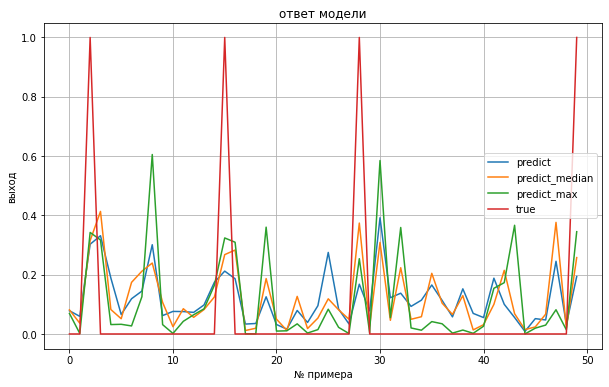

In [128]:
n = 50
plt.figure(figsize=(10, 6))
plt.plot(preds[:n], label='predict')
plt.plot(preds_median[:n], label='predict_median')
plt.plot(preds_max[:n], label='predict_max')
plt.plot(y_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [153]:
result = pd.DataFrame()

In [154]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_median)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
result = result.append({'name': 'median',
               'roc_auc': roc_auc_score(y_test, preds_median),
               'precision': precision[ix],
               'recall': recall[ix],
               'f_score': fscore[ix]}, ignore_index=True)

In [155]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_max)
fscore = (2 * precision * recall) / (precision + recall)
ix = np.argmax(fscore)
result = result.append({'name': 'max',
               'roc_auc': roc_auc_score(y_test, preds_max),
               'precision': precision[ix],
               'recall': recall[ix],
               'f_score': fscore[ix]}, ignore_index=True)

# 5
Сформировать на выходе единую таблицу, сравнивающую качество 2/3 разных метода получения эмбедингов пользователей: median, max, idf_mean по метрикам roc_auc, precision, recall, f_score

In [156]:
result

,f_score,name,precision,recall,roc_auc
0,0.698113,median,0.649123,0.755102,0.953004
1,0.740741,max,0.708955,0.775510,0.956442
